In [9]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df = pd.read_csv("Datos_Portadas.csv")
data = pd.DataFrame(df)
print(data.describe())

              year   cant_notas     politica         roja     deporte  \
count  5770.000000  5770.000000  5770.000000  5770.000000  5769.00000   
mean   2022.995494     3.867764     0.057886     0.368631     0.50702   
std       0.826402     0.665379     0.272590     0.710338     0.58943   
min    2022.000000     0.000000     0.000000     0.000000     0.00000   
25%    2022.000000     4.000000     0.000000     0.000000     0.00000   
50%    2023.000000     4.000000     0.000000     0.000000     0.00000   
75%    2024.000000     4.000000     0.000000     1.000000     1.00000   
max    2025.000000     6.000000     4.000000     5.000000     3.00000   

         accidente  comunitaria   nacionales  internacional  modelo_portada  \
count  5770.000000  5770.000000  5770.000000    5770.000000     5770.000000   
mean      0.389948     2.278683     0.239168       0.028769        0.008666   
std       0.624598     1.321180     0.618929       0.177238        0.092693   
min       0.000000     0.0

In [11]:
import nltk
from nltk.corpus import stopwords

spanish_stopwords = [
    "de", "la", "que", "el", "en", "y", "a", "los", "del", "se", "las",
    "por", "un", "para", "con", "no", "una", "su", "al", "es", "lo",
    "como", "más", "pero", "sus", "le", "ya", "o", "fue", "me", "si",
    "sin", "sobre", "este", "ya", "también", "entre", "cuando"
]

vectorizer = CountVectorizer(max_features=5000, stop_words=spanish_stopwords)

In [12]:
# Fill NaN values with an empty string
data["titulo"] = data["titulo"].fillna("").astype(str)
data["subtitular"] = data["subtitular"].fillna("").astype(str)

# Now safely merge them
data["text"] = data["titulo"] + " " + data["subtitular"]

In [13]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

# Download Spanish stopwords (only needed once)
nltk.download("stopwords")
spanish_stopwords = stopwords.words("spanish")

# Define range of parameters to test
n_components_range = [5, 10, 15, 20, 25]  # Example LDA n_components values
num_classes_range = [5, 10, 15, 20]  # Example LCA num_classes values

# Prepare an empty list to store the latent class distributions
distributions = []

for n_components in n_components_range:
    for num_classes in num_classes_range:
        # Apply LDA with Spanish stop words
        vectorizer = CountVectorizer(max_features=5000, stop_words=spanish_stopwords)
        X = vectorizer.fit_transform(data["text"])

        lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
        X_topics = lda.fit_transform(X)
        data["topic"] = X_topics.argmax(axis=1)

        # Apply OneHotEncoder
        encoder = OneHotEncoder(sparse_output=False)
        X_lca = encoder.fit_transform(data[["topic"]])

        # Apply LCA (GaussianMixture)
        lca_model = GaussianMixture(n_components=num_classes, covariance_type="full", random_state=42)
        data["latent_class"] = lca_model.fit_predict(X_lca)

        # Calculate class distribution
        class_distribution = data["latent_class"].value_counts().values
        distributions.append([n_components, num_classes, class_distribution])

# Convert results into a DataFrame for visualization
distributions_df = pd.DataFrame(distributions, columns=["n_components", "num_classes", "class_distribution"])

# Make sure all classes are represented in each distribution
distributions_df["class_count"] = distributions_df["class_distribution"].apply(lambda x: np.sum(x))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clu

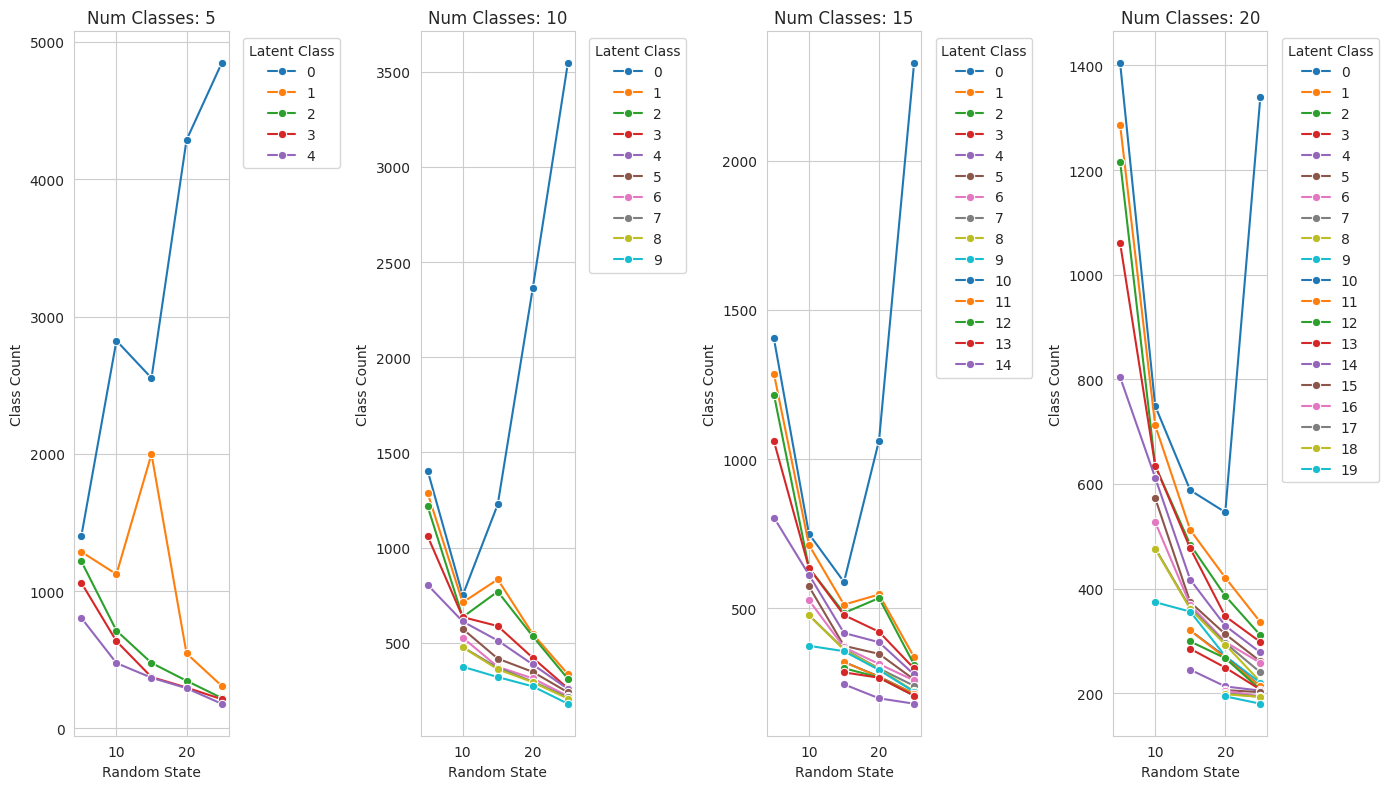

In [33]:
# Define a range of random states to test
random_state_range = [0, 42, 100, 2024]  # Example random state values

# Convert class distributions into DataFrame
plot_data = []

for entry in distributions:
    random_state, num_classes, class_distribution = entry  # Assume distributions now include random_state
    for class_idx, count in enumerate(class_distribution):
        plot_data.append([random_state, num_classes, class_idx, count])

# Create DataFrame
plot_df = pd.DataFrame(plot_data, columns=["random_state", "num_classes", "class_idx", "count"])

# Plot distributions for each num_classes set
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

for idx, num_classes in enumerate(num_classes_range):
    plt.subplot(1, len(num_classes_range), idx + 1)
    subset = plot_df[plot_df["num_classes"] == num_classes]
    sns.lineplot(
        x="random_state", y="count", hue="class_idx", data=subset, marker="o", palette="tab10"
    )
    plt.title(f"Num Classes: {num_classes}")
    plt.xlabel("Random State")
    plt.ylabel("Class Count")
    plt.legend(title="Latent Class", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

plt.show()

In [54]:
# Define number of latent classes
num_classes = 10  

# Fit LCA model using Gaussian Mixture Model (GMM)
lca_model = GaussianMixture(n_components=num_classes, covariance_type="full", random_state=2000)
data["latent_class"] = lca_model.fit_predict(X_lca)

# Check class distribution
print(data["latent_class"].value_counts())

latent_class
3    1984
9    1035
2     738
0     393
6     336
5     298
1     278
8     261
7     240
4     207
Name: count, dtype: int64
